In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Implementing CCC-GARCH Model For Multivariate Volatility Forecasting

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model

1- Specify the risky asset and the time horizon

In [4]:
RISKY_ASSET = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSET)
START_DATE = '2014-12-31'
END_DATE = '2020-12-31'

2- Download data from Yahoo finance

In [5]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE)
print(f'Downloaded {df.shape[0]} rows of data')

[*********************100%%**********************]  3 of 3 completed
Downloaded 1511 rows of data


3- Calculate daily returns

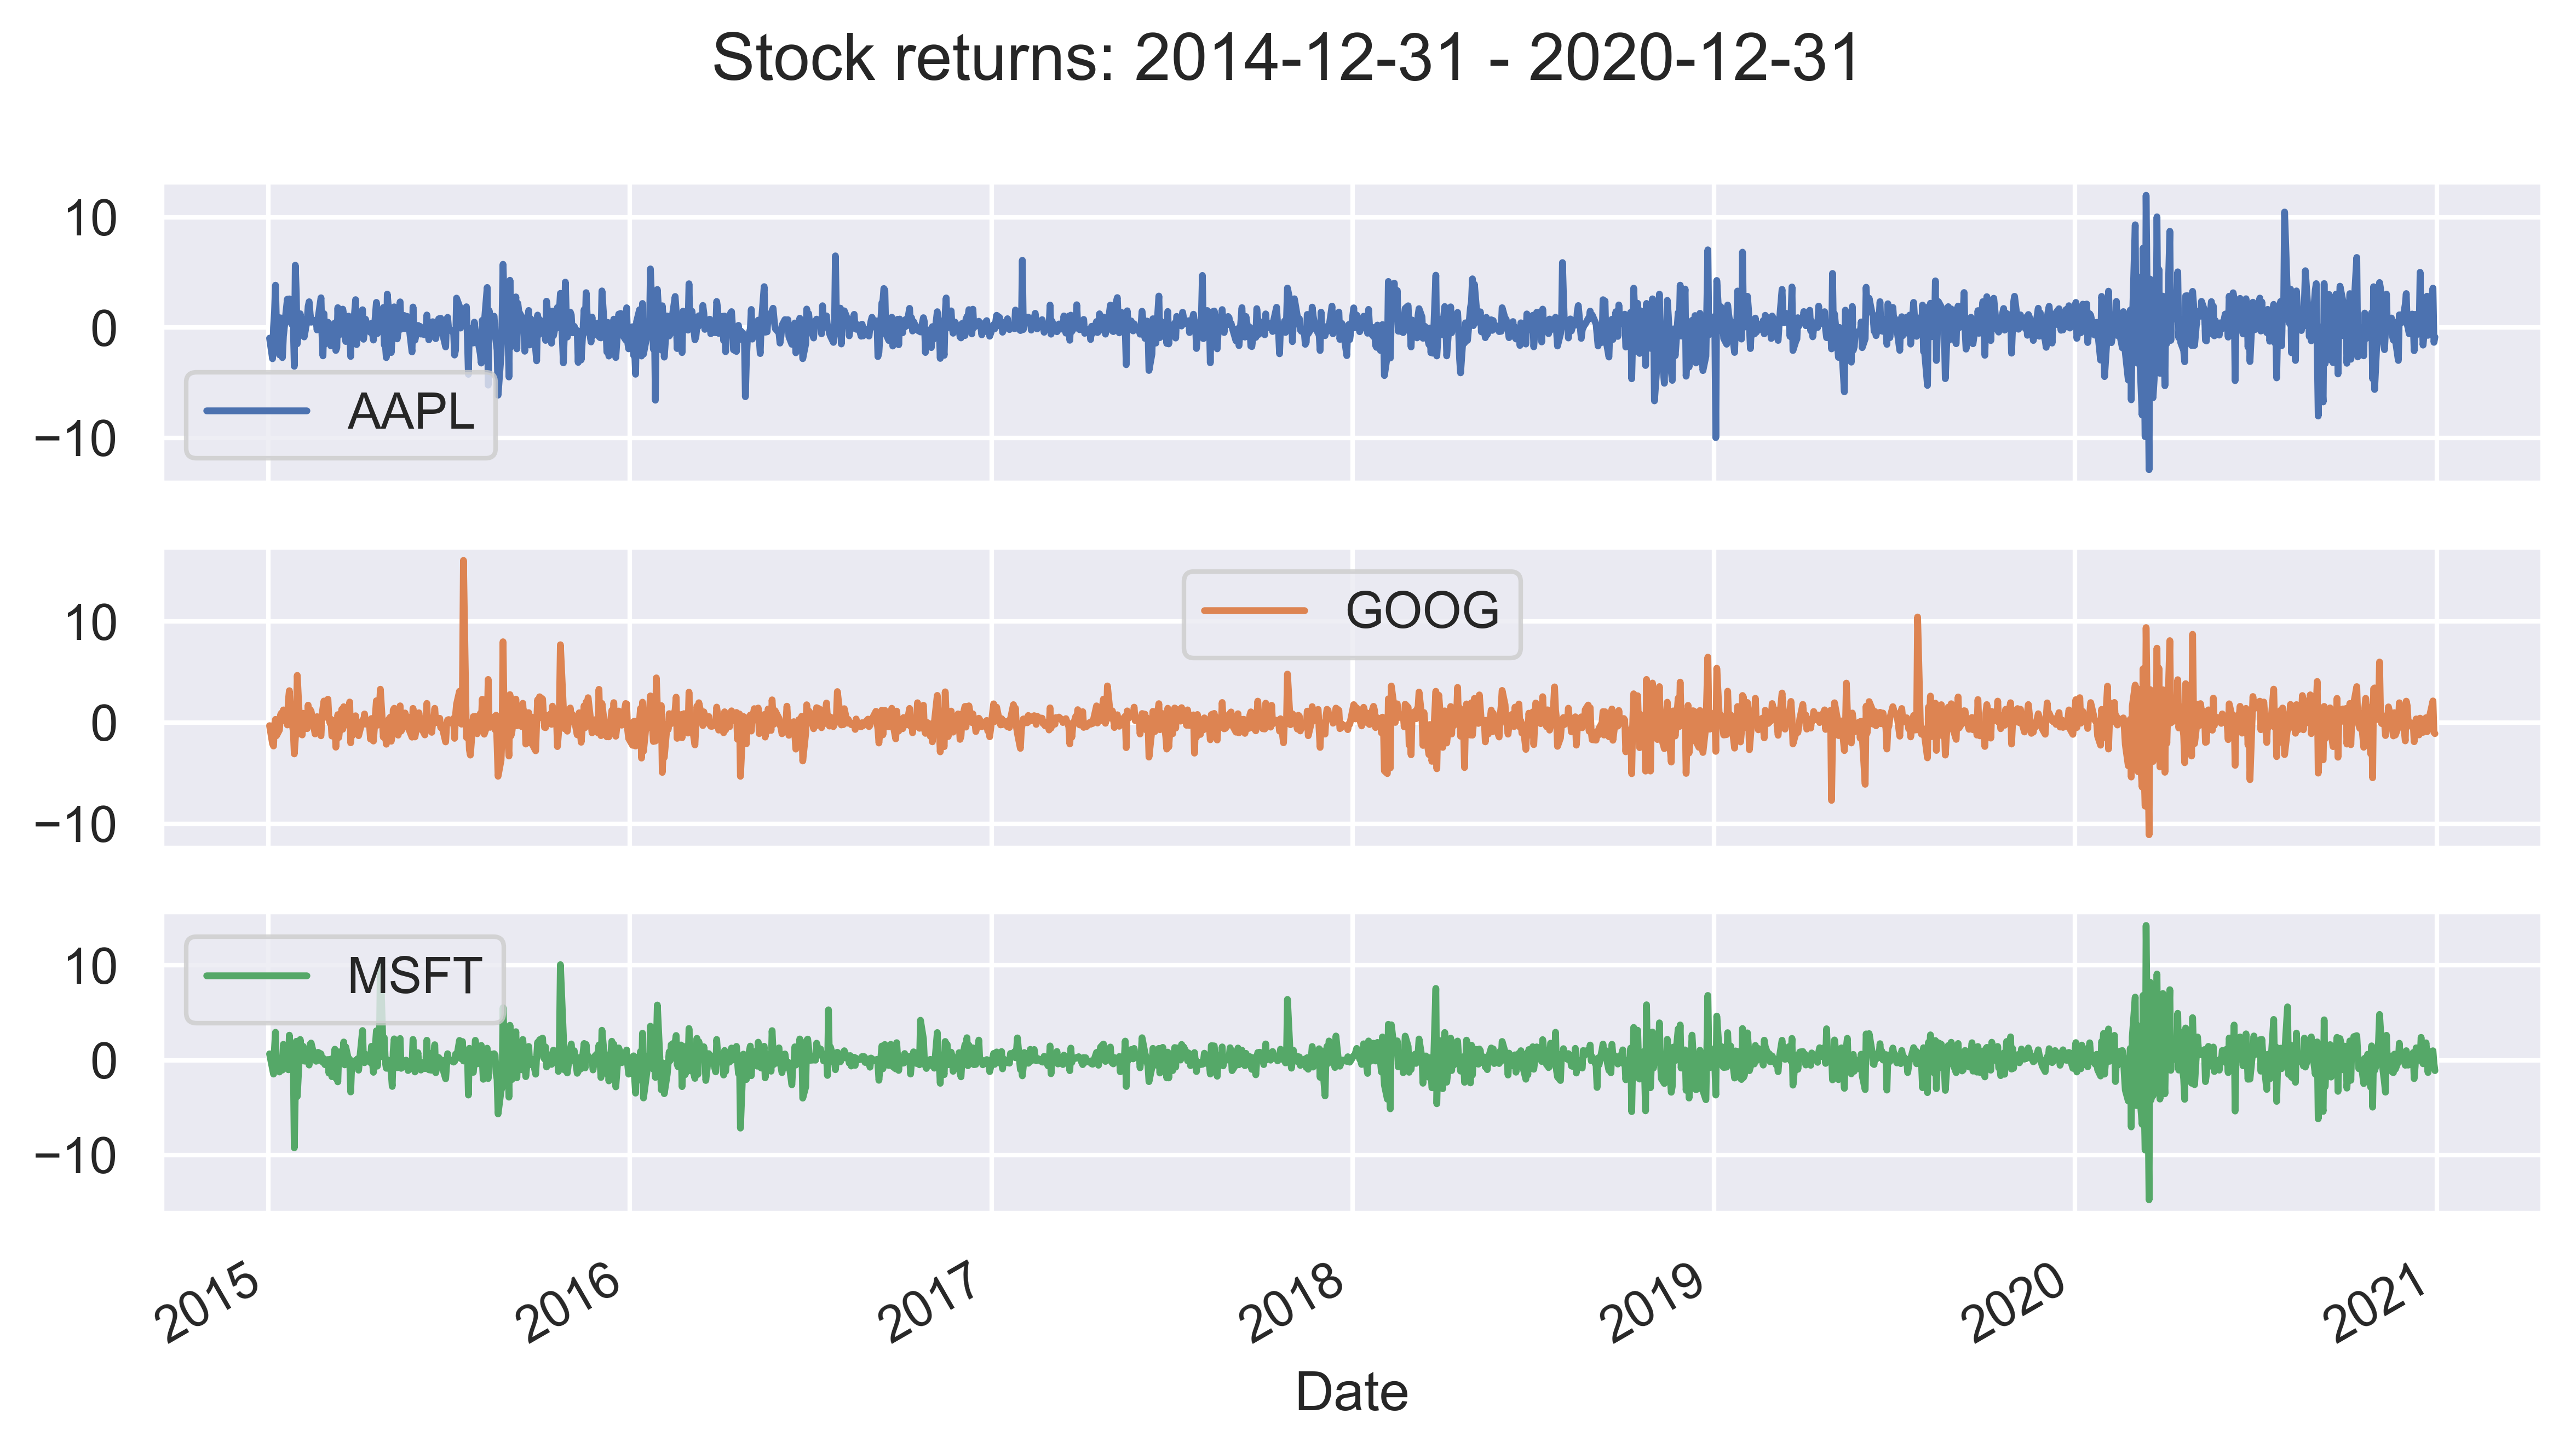

In [6]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()
plt.show()

4- Define lists for storing objects

In [7]:
coeffs = []
cond_vol = []
std_resids = []
models = []

5- Estimate the univariate GARCH models

In [8]:
for asset in returns.columns:
    #specify and fit the model
    model = arch_model(returns[asset], mean='Constant', vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, disp='off')

    # store results in the lists
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

6- Store the results in DataFrame

In [10]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose().set_axis(returns.columns, axis='columns')
std_resids_df = pd.DataFrame(std_resids).transpose().set_axis(returns.columns, axis='columns')

In [11]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.196093,0.180925,0.145503,0.803448
GOOG,0.117260,0.322269,0.193567,0.704221
MSFT,0.140648,0.269202,0.231541,0.693438


7- Calculate the constant conditional correlation matrix(R)

In [12]:
R = std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

8- Calculate the 1-step ahead forecast of the conditional covariance matrix

In [16]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])

# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))

# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [17]:
H

array([[3.47176237, 1.38405087, 1.3128623 ],
       [1.38405087, 2.02897161, 1.2011281 ],
       [1.3128623 , 1.2011281 , 1.6423023 ]])